# Domain Adaptation between digits

#### *Rémi Flamary, Nicolas Courty*

In this practical session we will apply on digit classification the OT based domain adaptation method proposed in 

N. Courty, R. Flamary, D. Tuia, A. Rakotomamonjy, "[Optimal transport for domain adaptation](http://remi.flamary.com/biblio/courty2016optimal.pdf)", Pattern Analysis and Machine Intelligence, IEEE Transactions on , 2016.

![otda.png](http://remi.flamary.com/cours/otml/otda.png)

To this end we will try and adapt between the MNIST and USPS datasets. Since those datasets do not have the same resolution (28x28 and 16x16 for MNSIT and USPS) we perform a zeros padding of the USPS digits 


####  Import modules

First we import the relevant modules. Note that you will need ```sklearn``` to learn the Support Vector Machine cleassifier and to projet the data with TSNE.


In [2]:
import numpy as np # always need it
import pylab as pl # do the plots

from sklearn.svm import SVC
from sklearn.manifold import TSNE
import ot
import ot.plot

### Loading data and normalization

We load the data in memory and perform a normalization of the images so that they all sum to 1.

Note that every line in the ```xs``` and ```xt``` is a 28x28 image.

In [3]:
data=np.load('data/mnist_usps.npz')


Xs,ys=data['xs'],data['ys']
Xt,yt=data['xt'],data['yt']


# normalization
Xs=Xs/Xs.sum(1,keepdims=True) # every l
Xt=Xt/Xt.sum(1,keepdims=True)

ns=Xs.shape[0]
nt=Xt.shape[0]

### Vizualizing Source (MNIST) and Target (USPS) datasets





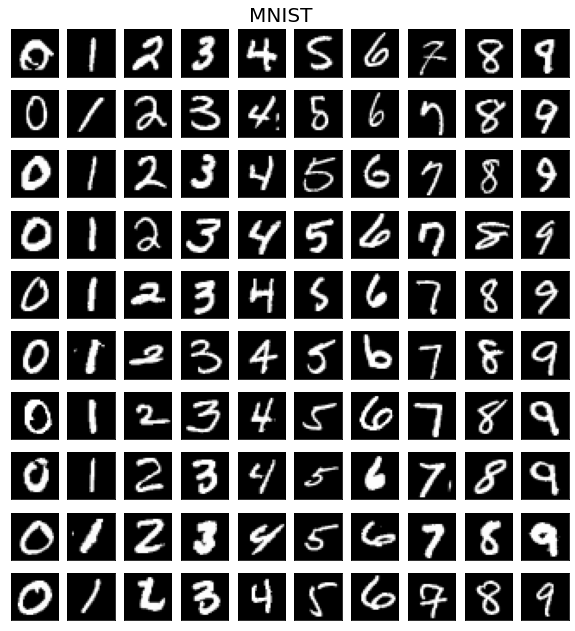

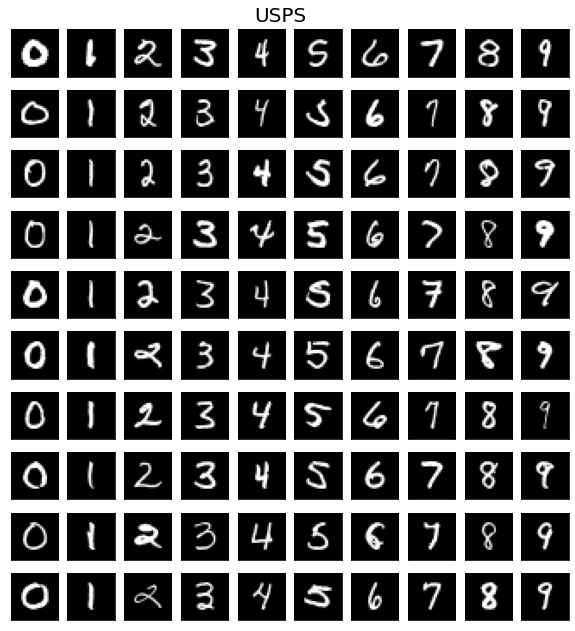

In [4]:

# function for plotting images
def plot_image(x):
    pl.imshow(x.reshape((28,28)),cmap='gray')
    pl.xticks(())
    pl.yticks(())


nb=10

# Fisrt we plot MNIST
pl.figure(1,(nb,nb))
for i in range(nb*nb):
    pl.subplot(nb,nb,1+i)
    c=i%nb
    plot_image(Xs[np.where(ys==c)[0][i//nb],:])
pl.gcf().suptitle("MNIST", fontsize=20);
pl.gcf().subplots_adjust(top=0.95)
    
# Then we plot USPS
pl.figure(2,(nb,nb))
for i in range(nb*nb):
    pl.subplot(nb,nb,1+i)
    c=i%nb
    plot_image(Xt[np.where(yt==c)[0][i//nb],:])
pl.gcf().suptitle("USPS", fontsize=20);
pl.gcf().subplots_adjust(top=0.95)


Note that there is a large discrepancy especially between the 1,2 and 5 that have differnt shapes in both datasets.

Also since we have performe zero padding on the USPS digits theyr are in average slightly smaller than NMSIT that can take the whole image.


### Classification without domain adaptation

We learn a classifier on the MNIST dataset (we will not be state of the art on 1000 samples). We evaluate this claddifier on MNIST and on the USPS dataset.

In [5]:

# Train SVM with reg parameter C=1 and RBF kernel parameter gamma=1e1
clf=SVC(C=1,gamma=1e2) # might take time
clf.fit(Xs,ys)

# Compute accuracy
ACC_MNIST=clf.score(Xs,ys) # beware of overfitting !
ACC_USPS=clf.score(Xt,yt)

print('ACC_MNIST={:1.3f}'.format(ACC_MNIST))
print('ACC_USPS={:1.3f}'.format(ACC_USPS))

ACC_MNIST=0.978
ACC_USPS=0.687


There is a very large loss in performances. This can be better explained by performning a TSNE embedding on the data.

### TSNE of the Source/Target domains

[t-distributed stochastic neighbor embedding (TSNE)](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) is a well knwn approch that allow projection of complex high dimensionnal data in a lower dimensionnal space while keeping its structure.



In [6]:

xtot=np.concatenate((Xs,Xt),axis=0) # all data

xp=TSNE().fit_transform(xtot) # this maigh take a while (30 sec on my laptop)

# separate again but now in 2D
xps=xp[:ns,:] 
xpt=xp[ns:,:]


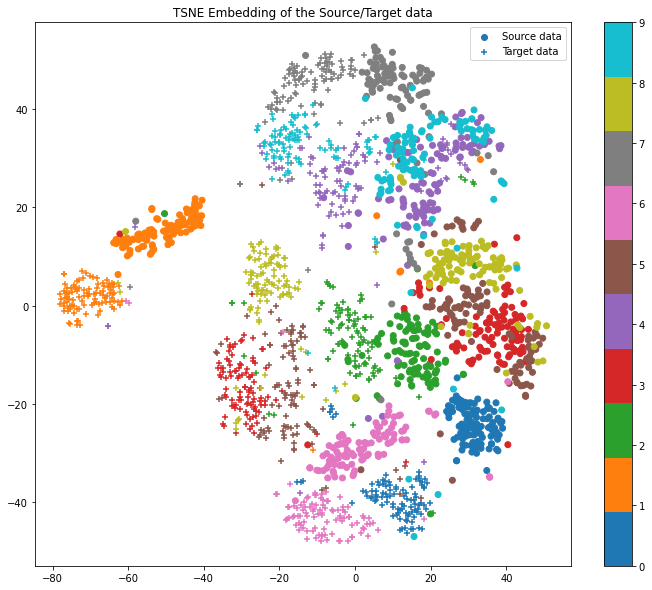

In [7]:

pl.figure(3,(12,10))

pl.scatter(xps[:,0],xps[:,1],c=ys,marker='o',cmap='tab10',label='Source data')
pl.scatter(xpt[:,0],xpt[:,1],c=yt,marker='+',cmap='tab10',label='Target data')
pl.legend()
pl.colorbar()
pl.title('TSNE Embedding of the Source/Target data');

We can see that while the classes are relatively well clustured, the clusters from source and target dataset rarely overlapp. This is the main reason for the important loss in performance between Source and target.

### Optimal Transport Domain Adaptation (OTDA)

Now we perform domain adaptation with the following 3 steps illustrated at the top of the notebook:

1. Compute the OT matrix betxeen source and target datasets
1. Perform OT mapping with barycentric mapping (```np.dot```).
1. Estimate classifier on the mapped source samples

#### 1. OT between domain

First we compute the Cost matrix and vizualize it. Note that the sampels are sorted by class in both source and target domains in order to better see the class based structure in the cost matrix and OT matrix.




In [8]:
result = ot.dist(Xs,Xt,metric='sqeuclidean')
result

array([[0.0033442 , 0.00624958, 0.00773067, ..., 0.01641104, 0.02872394,
        0.01531469],
       [0.00771359, 0.01259832, 0.00969806, ..., 0.02154451, 0.03424926,
        0.02244696],
       [0.00234399, 0.00622078, 0.00565706, ..., 0.01659719, 0.02717365,
        0.01615301],
       ...,
       [0.00589426, 0.01052157, 0.0101858 , ..., 0.01877926, 0.02652658,
        0.01708165],
       [0.0065055 , 0.01073709, 0.00905422, ..., 0.02213761, 0.02998623,
        0.02173255],
       [0.00634836, 0.01270905, 0.00805018, ..., 0.01598181, 0.02623818,
        0.01577956]])

We can clearly see the (noisy) structure in the matrix. It is also interesting to note that the class 1 in usps (second column) is particularly different fromm all the other classes in MNIST data (even class 1).


Next we compute the OT matrix using exact LP OT [ot.emd](http://pot.readthedocs.io/en/stable/all.html#ot.emd) or regularized OT with  [ot.sinkhorn](http://pot.readthedocs.io/en/stable/all.html#ot.sinkhorn).

In [16]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs, Xt=Xt)

# Sinkhorn Transport with Group lasso regularization
ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e=1e-1, reg_cl=1e0)
ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)

# transport source samples onto target samples
transp_Xs_emd = ot_emd.transform(Xs=Xs)
transp_Xs_sinkhorn = ot_sinkhorn.transform(Xs=Xs)
transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)



We can see that most of the trasportation is done in the block-diagonal which means that in average samples from one class are affected to the proper classs in the target.

#### 2/3 Mapping + Classification

Now we perform the barycentric mapping of the samples and traing the classifier on the mapped samples. We recomend to use a smaller ```gamma=1e1``` here because some samples will be mislabeled and a smooth classifier will work better.

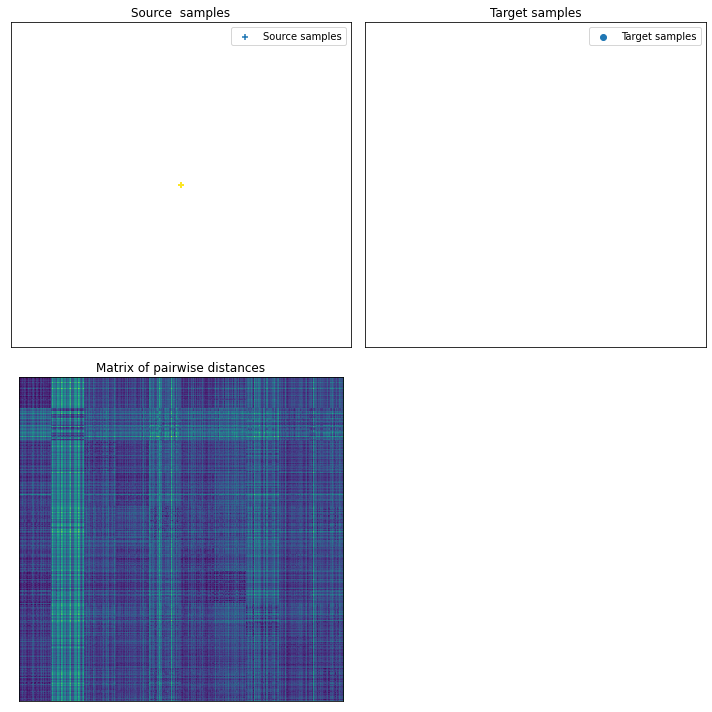

In [10]:
# Fig 1 : plots source and target samples + matrix of pairwise distance

pl.figure(1, figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(2, 2, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')

pl.subplot(2, 2, 3)
pl.imshow(result, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Matrix of pairwise distances')
pl.tight_layout()




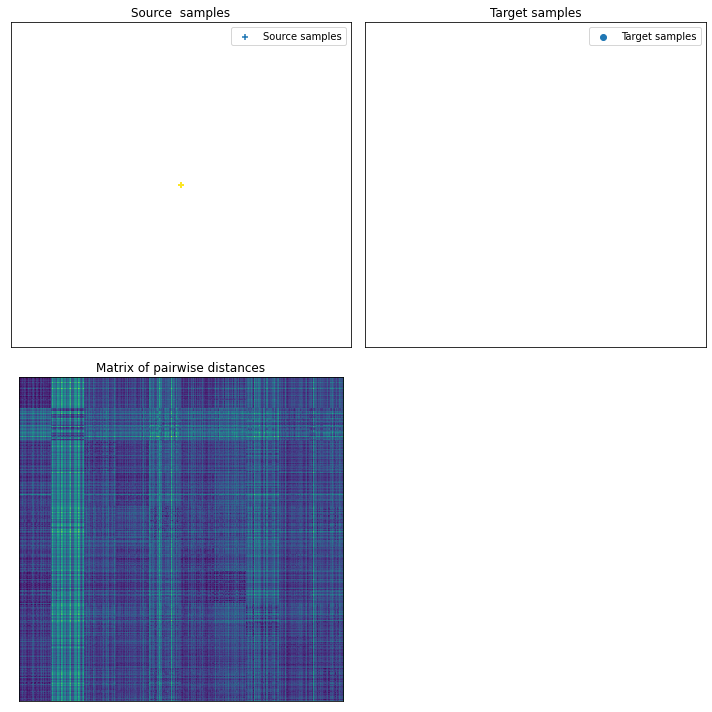

In [21]:
# Fig 1 : plots source and target samples + matrix of pairwise distance
# ---------------------------------------------------------------------

pl.figure(1, figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(2, 2, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.legend(loc=0)
pl.title('Target samples')

pl.subplot(2, 2, 3)
pl.imshow(result, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Matrix of pairwise distances')
pl.tight_layout()




In [ ]:
# Fig 2 : plots optimal couplings for the different methods

pl.figure(2, figsize=(10, 6))

pl.subplot(2, 3, 1)
pl.imshow(ot_emd.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nEMDTransport')

pl.subplot(2, 3, 2)
pl.imshow(ot_sinkhorn.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornTransport')

pl.subplot(2, 3, 3)
pl.imshow(ot_lpl1.coupling_, interpolation='nearest')
pl.xticks([])
pl.yticks([])
pl.title('Optimal coupling\nSinkhornLpl1Transport')

pl.subplot(2, 3, 4)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_emd.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nEMDTransport')

pl.subplot(2, 3, 5)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_sinkhorn.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornTransport')

pl.subplot(2, 3, 6)
ot.plot.plot2D_samples_mat(Xs, Xt, ot_lpl1.coupling_, c=[.5, .5, 1])
pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
pl.xticks([])
pl.yticks([])
pl.title('Main coupling coefficients\nSinkhornLpl1Transport')
pl.tight_layout()


KeyboardInterrupt: 

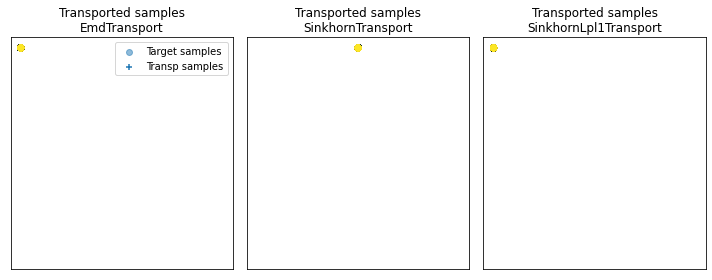

In [22]:
# Fig 3 : plot transported samples
# --------------------------------

# display transported samples
pl.figure(4, figsize=(10, 4))
pl.subplot(1, 3, 1)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_emd[:, 0], transp_Xs_emd[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nEmdTransport')
pl.legend(loc=0)
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 2)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_sinkhorn[:, 0], transp_Xs_sinkhorn[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornTransport')
pl.xticks([])
pl.yticks([])

pl.subplot(1, 3, 3)
pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o',
           label='Target samples', alpha=0.5)
pl.scatter(transp_Xs_lpl1[:, 0], transp_Xs_lpl1[:, 1], c=ys,
           marker='+', label='Transp samples', s=30)
pl.title('Transported samples\nSinkhornLpl1Transport')
pl.xticks([])
pl.yticks([])

pl.tight_layout()
pl.show()



We can see that the adaptation with EMD leads to a performance gain of nearly 10%. You can get even better performances using entropic regularized OT or group lasso regularization.

#### TNSE vizualization for OTDA

In order to see the effect of the adaptation we can perform a new TSNE embedding to see if the classes are betetr aligned.



In [ ]:
#done above


We can see that when using emd solver the OT matrix is a permutation wo the samples are exactly superimposed. In average the classes are also well transported but there exist a number of badly transported samples that have a class permutation.


#### Transported sampels vizualization

We can now also plot the transported samples.

In [1]:
#done above

Those are the same MNIST samples that have been plotted above but after trasnportation. There are several samples that are transported on the wrong class but again in average the class information is preserved which explain the accuracy gain.

### OTDA with regularization

We now recomend to try regularized OT and to redo classification/TSNE/Vizu to see the impact of the regularization in term of performances, TNSE and transported samples. 

In [ ]:
#done above